In [1]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation.eval import run_comprehensive_evaluation

In [2]:
cluster_flann_sift_path = "evaluation/clusters/clusters_flann_with_sift.json"
cluster_flann_disk_path = "evaluation/clusters/clusters_flann_with_disk.json"
train_label_path = "data/train_labels.csv"

## eval cluster flann with sift

In [5]:
run_comprehensive_evaluation(cluster_flann_sift_path, train_label_path)

Running comprehensive cluster evaluation...

Evaluating dataset: pt_sacrecoeur_trevi_tajmahal

Evaluating dataset: pt_stpeters_stpauls

Evaluating dataset: pt_brandenburg_british_buckingham

Evaluating dataset: imc2023_heritage

Evaluating dataset: imc2024_lizard_pond

Evaluating dataset: fbk_vineyard

Evaluating dataset: imc2024_dioscuri_baalshamin

Evaluating dataset: amy_gardens

Evaluating dataset: imc2023_haiper

Evaluating dataset: pt_piazzasanmarco_grandplace

Evaluating dataset: stairs

Evaluating dataset: imc2023_theather_imc2024_church

Evaluating dataset: ETs

COMPREHENSIVE CLUSTER EVALUATION RESULTS

OVERALL METRICS ACROSS ALL DATASETS:
  Average Precision: 0.8904
  Average Recall: 0.7027
  Average F1 Score: 0.7190
  Average ARI: 0.5054
  Average NMI: 0.6260
  Average Homogeneity: 0.7972
  Average Completeness: 0.5970
  Average V-Measure: 0.6260
  Datasets Evaluated: 13

------------------------------------------------------------
DATASET: pt_sacrecoeur_trevi_tajmahal
-----

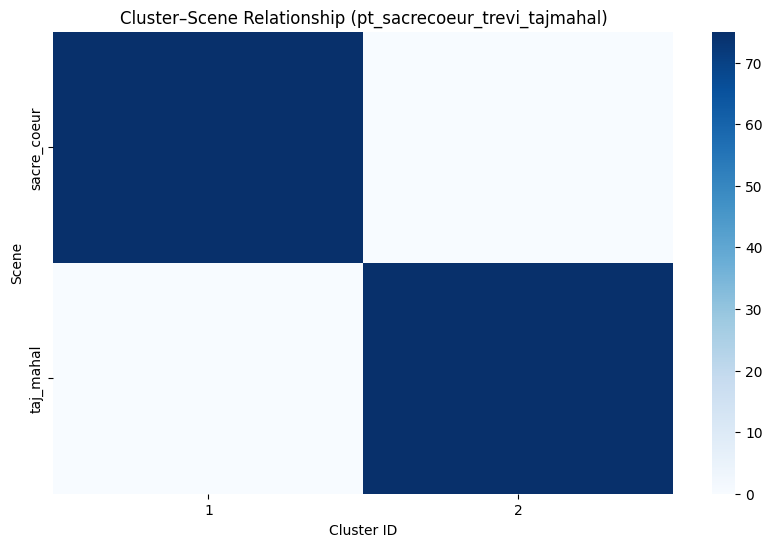

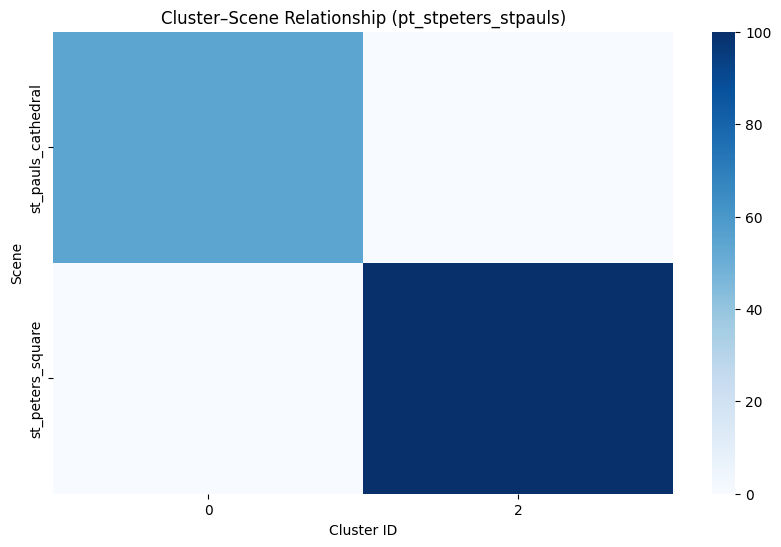

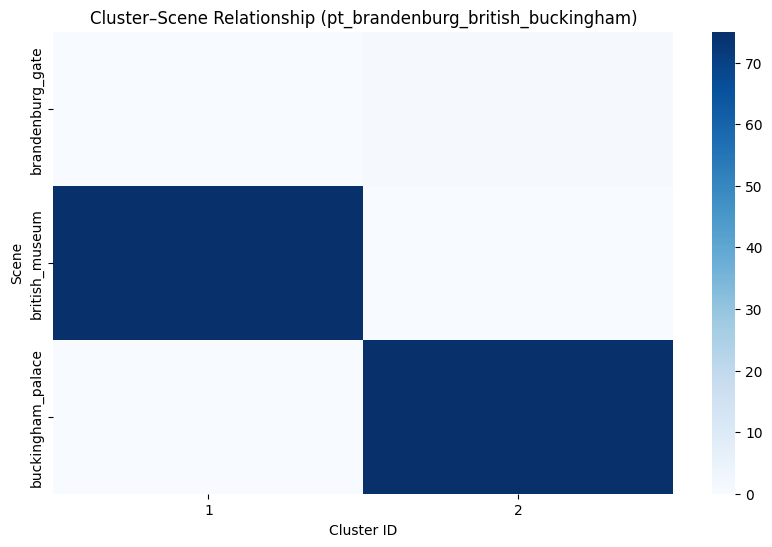

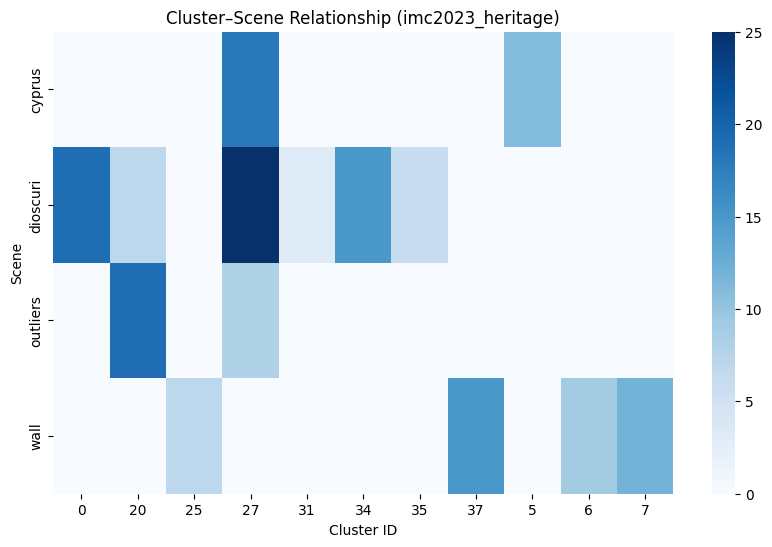

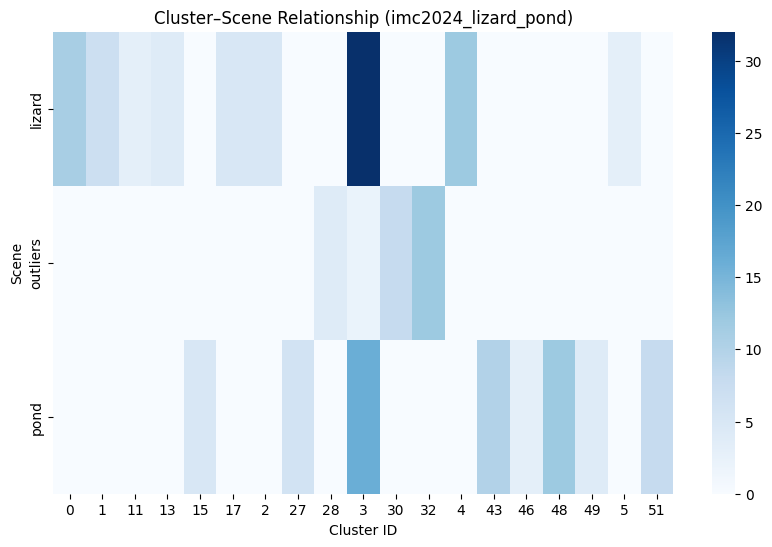

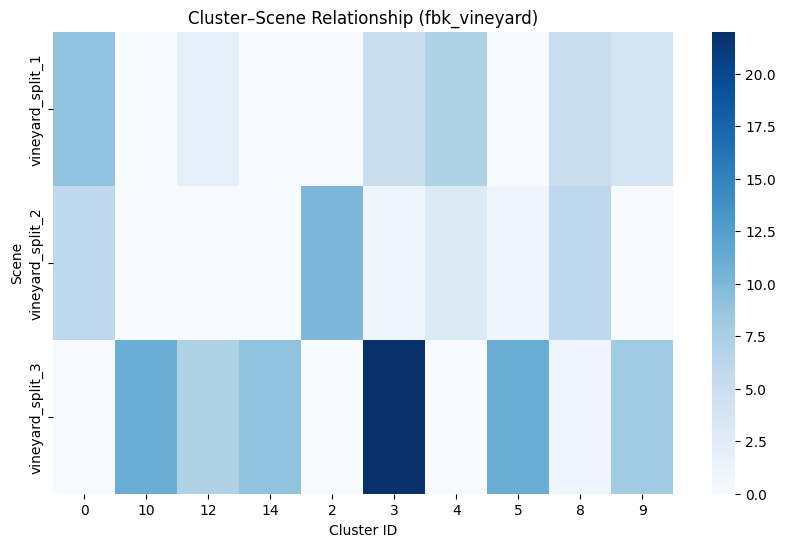

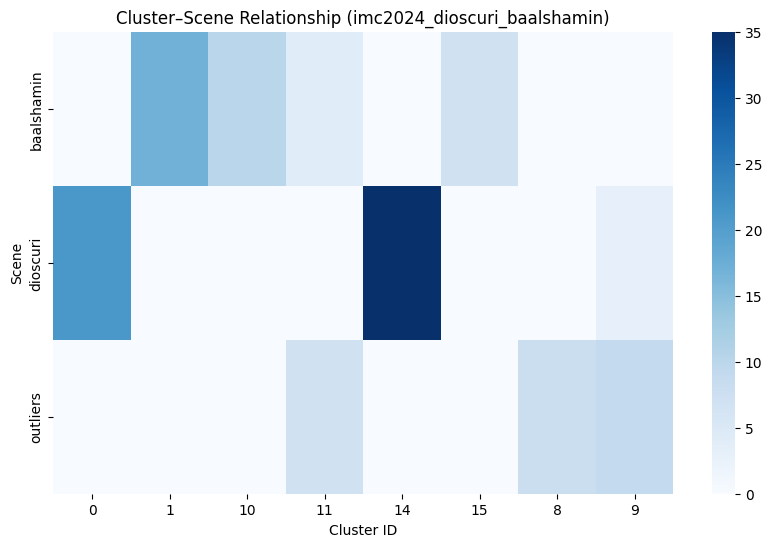

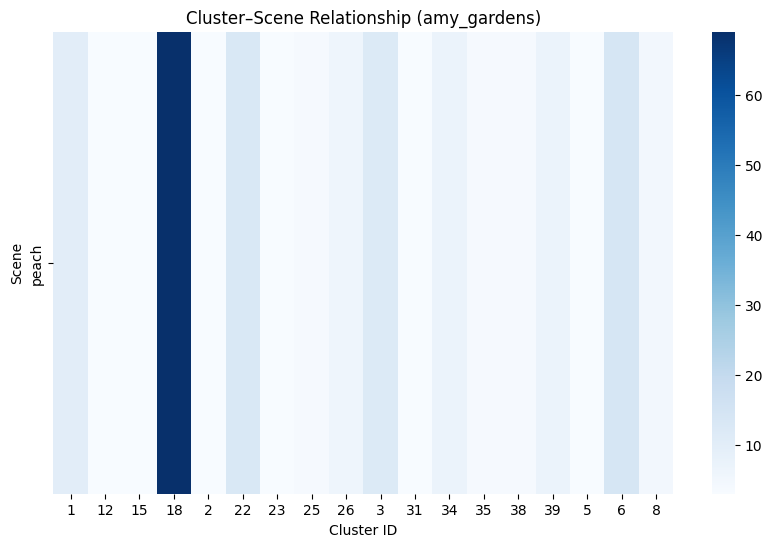

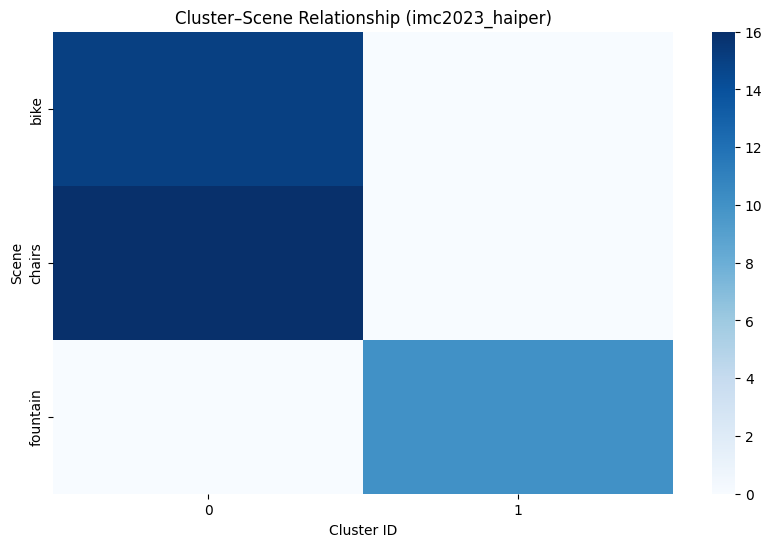

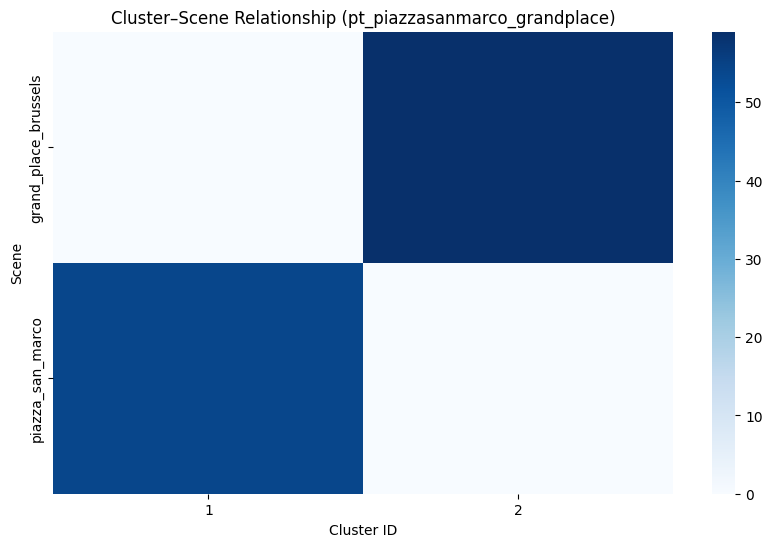

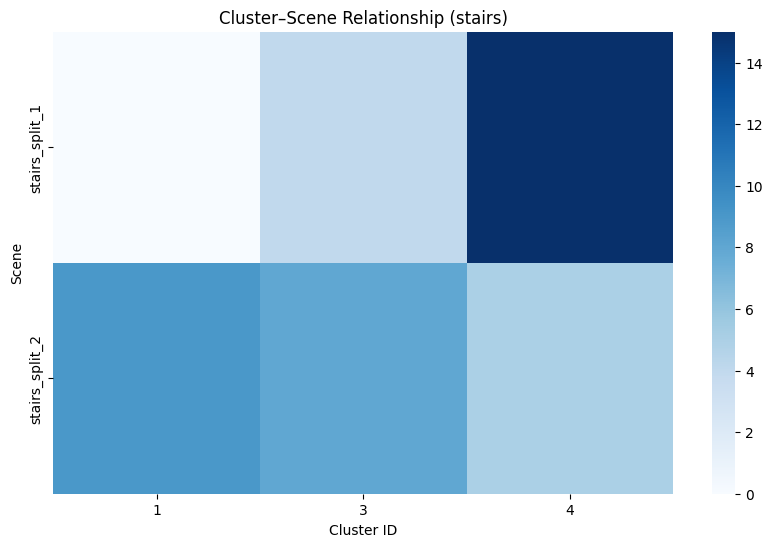

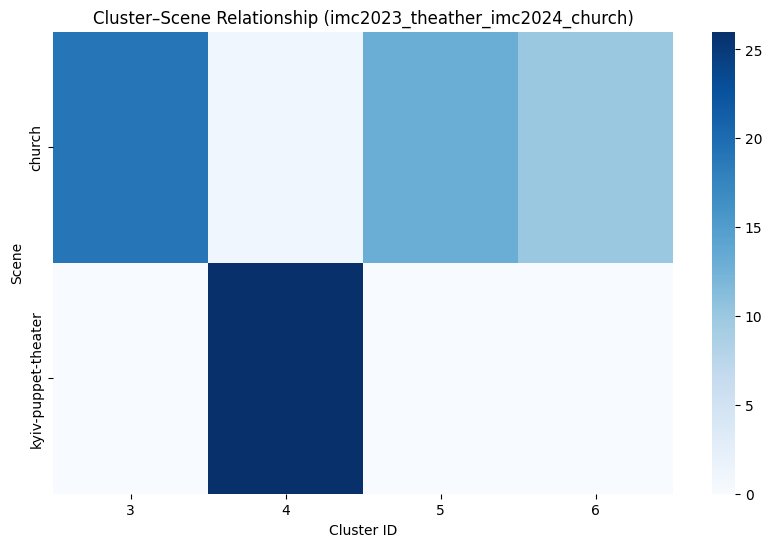

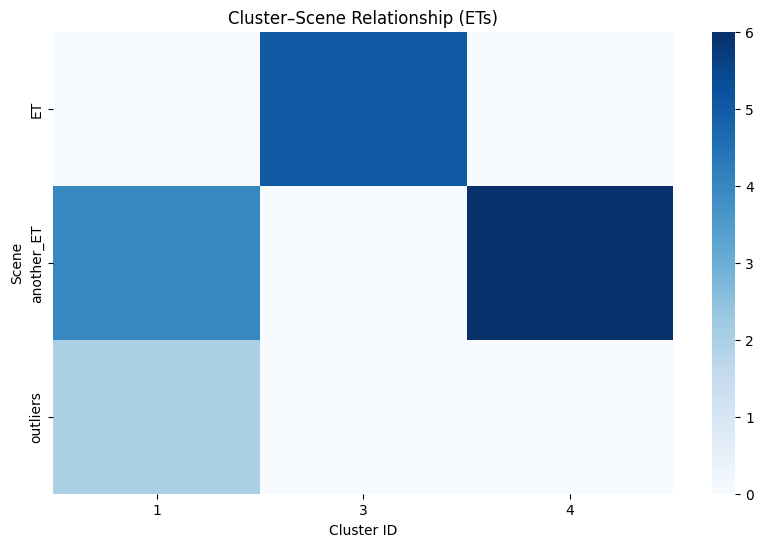

                              dataset cluster_id      majority_scene  \
0        pt_sacrecoeur_trevi_tajmahal          1         sacre_coeur   
1        pt_sacrecoeur_trevi_tajmahal          2           taj_mahal   
2                 pt_stpeters_stpauls          0  st_pauls_cathedral   
3                 pt_stpeters_stpauls          2    st_peters_square   
4   pt_brandenburg_british_buckingham          1      british_museum   
..                                ...        ...                 ...   
81    imc2023_theather_imc2024_church          5              church   
82    imc2023_theather_imc2024_church          6              church   
83                                ETs          1          another_ET   
84                                ETs          3                  ET   
85                                ETs          4          another_ET   

    precision    recall        f1  size  outliers  
0    1.000000  1.000000  1.000000    75         0  
1    1.000000  1.000000  1.0000

In [6]:
# Load ground truth
labels = pd.read_csv(train_label_path)
# expected columns: dataset, scene, image

# Load clusters
with open(cluster_flann_sift_path) as f:
    clusters = json.load(f)

results = []

for dataset, content in clusters.items():
    records = []
    for cluster_id, imgs in content["clusters"].items():
        for img in imgs:
            records.append([dataset, cluster_id, img])
    df_clusters = pd.DataFrame(records, columns=["dataset", "cluster_id", "image"])

    # Merge with ground truth
    df = df_clusters.merge(labels, on=["dataset", "image"], how="left")

    cluster_metrics = []

    for cluster_id, group in df.groupby("cluster_id"):
        scene_counts = Counter(group["scene"])
        if not scene_counts:
            continue

        # Majority scene
        majority_scene, majority_count = scene_counts.most_common(1)[0]
        total_cluster = len(group)

        # Precision = purity
        precision = majority_count / total_cluster

        # Recall = how much of that scene we captured
        total_scene_images = len(labels[(labels["dataset"] == dataset) & 
                                        (labels["scene"] == majority_scene)])
        recall = majority_count / total_scene_images

        # F1
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

        cluster_metrics.append({
            "dataset": dataset,
            "cluster_id": cluster_id,
            "majority_scene": majority_scene,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "size": total_cluster,
            "outliers": total_cluster - majority_count
        })

    cluster_report = pd.DataFrame(cluster_metrics)
    results.append(cluster_report)

    # Heatmap cluster vs. scene
    confusion = pd.crosstab(df["scene"], df["cluster_id"])
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion, cmap="Blues")
    plt.title(f"Cluster–Scene Relationship ({dataset})")
    plt.xlabel("Cluster ID")
    plt.ylabel("Scene")
    plt.show()

# Combine all datasets into one big table
final_report = pd.concat(results, ignore_index=True)
print(final_report)

## eval cluster flann with disk

In [7]:
run_comprehensive_evaluation(cluster_flann_disk_path, train_label_path)

Running comprehensive cluster evaluation...

Evaluating dataset: fbk_vineyard

Evaluating dataset: pt_sacrecoeur_trevi_tajmahal

Evaluating dataset: pt_piazzasanmarco_grandplace

Evaluating dataset: imc2024_lizard_pond

Evaluating dataset: pt_brandenburg_british_buckingham

Evaluating dataset: amy_gardens

Evaluating dataset: imc2024_dioscuri_baalshamin

Evaluating dataset: imc2023_haiper

Evaluating dataset: pt_stpeters_stpauls

Evaluating dataset: imc2023_heritage

Evaluating dataset: imc2023_theather_imc2024_church

Evaluating dataset: stairs

Evaluating dataset: ETs

COMPREHENSIVE CLUSTER EVALUATION RESULTS

OVERALL METRICS ACROSS ALL DATASETS:
  Average Precision: 0.9881
  Average Recall: 0.5100
  Average F1 Score: 0.6249
  Average ARI: 0.3894
  Average NMI: 0.5889
  Average Homogeneity: 0.9816
  Average Completeness: 0.4664
  Average V-Measure: 0.5889
  Datasets Evaluated: 12

------------------------------------------------------------
DATASET: fbk_vineyard
---------------------

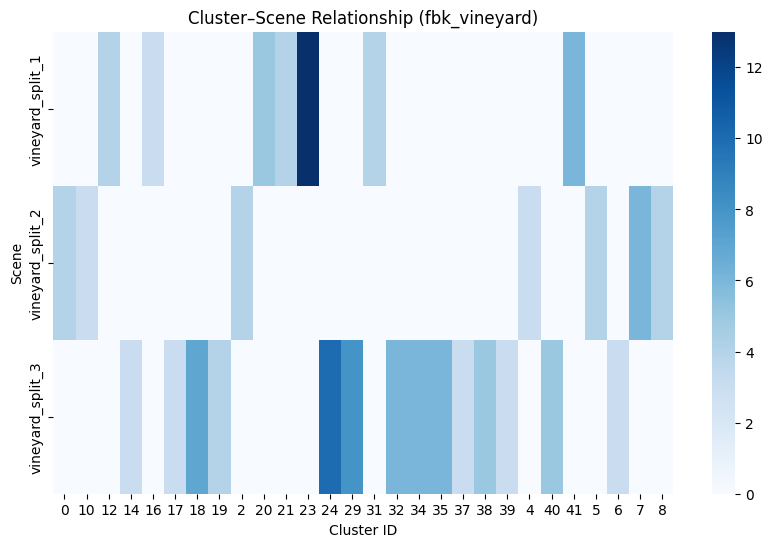

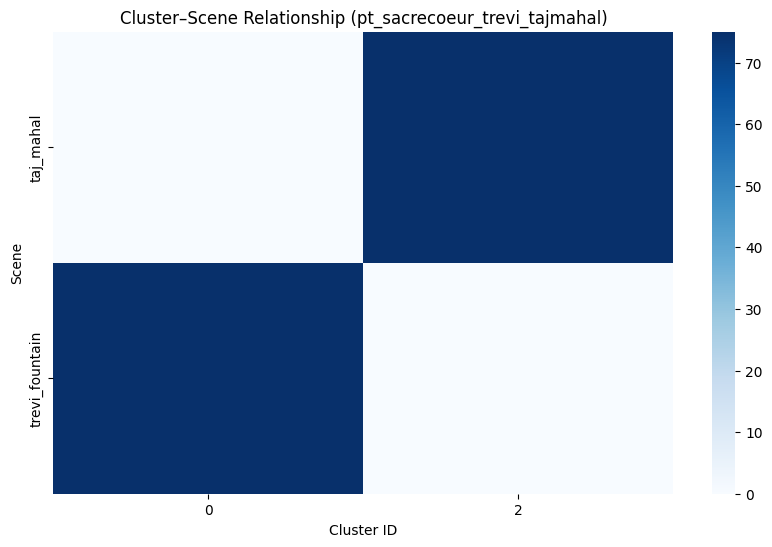

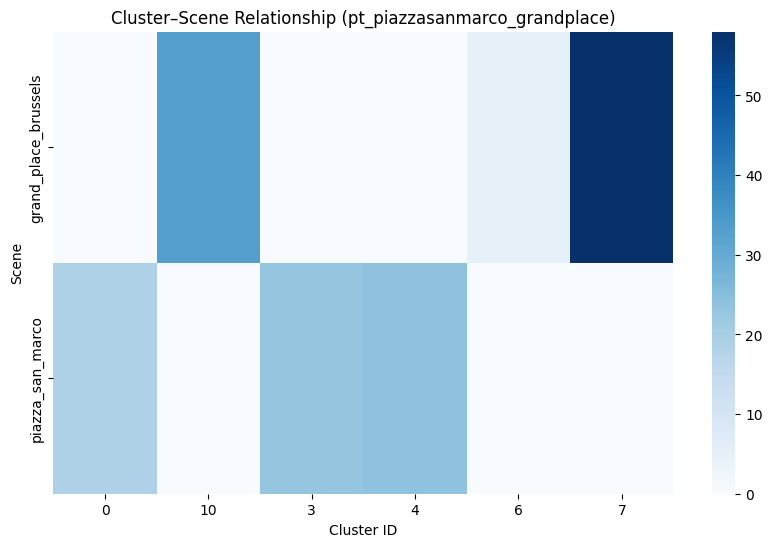

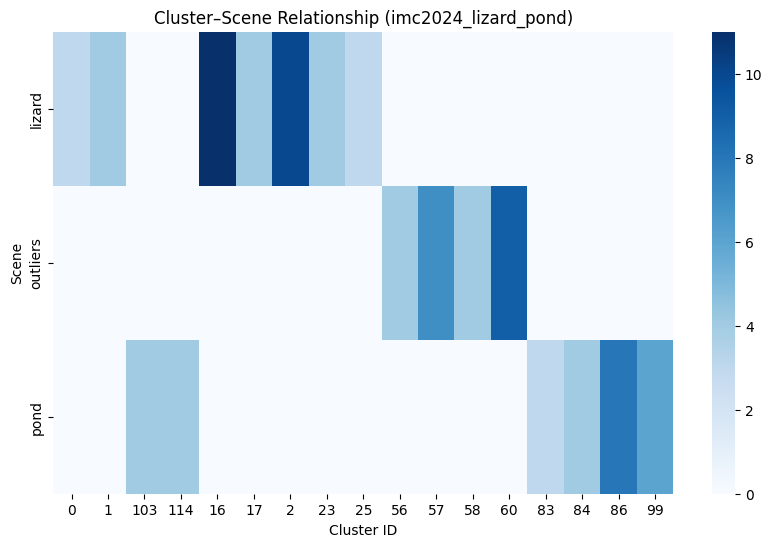

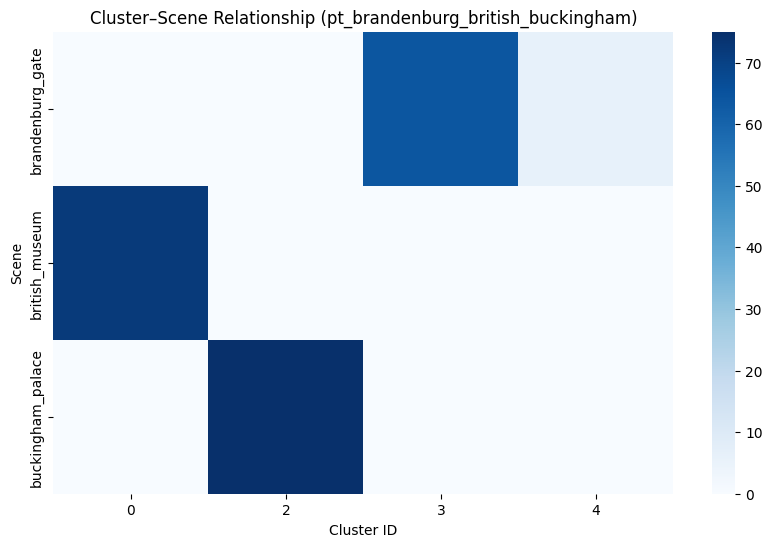

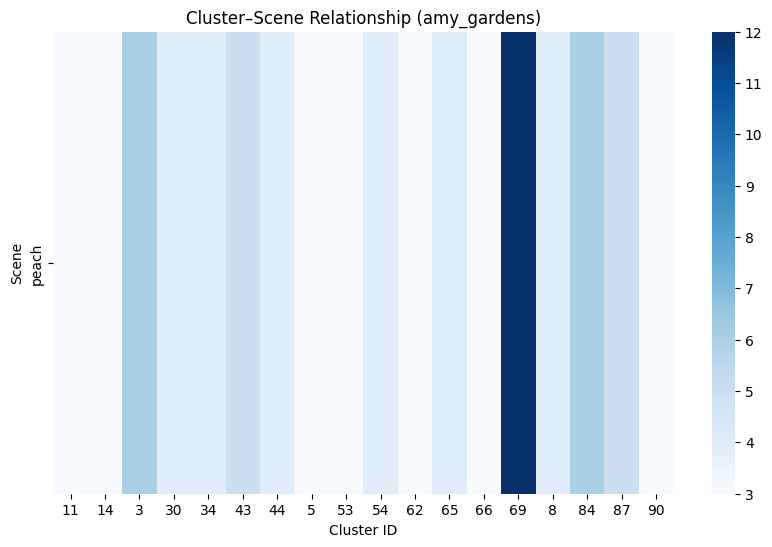

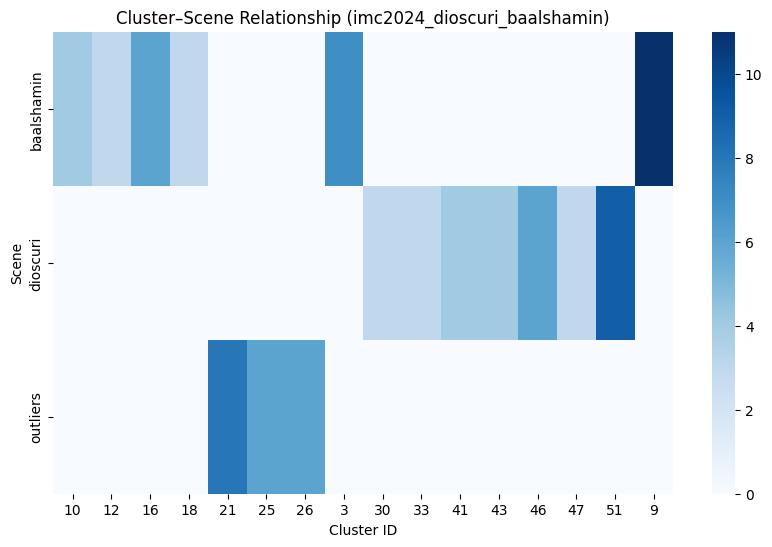

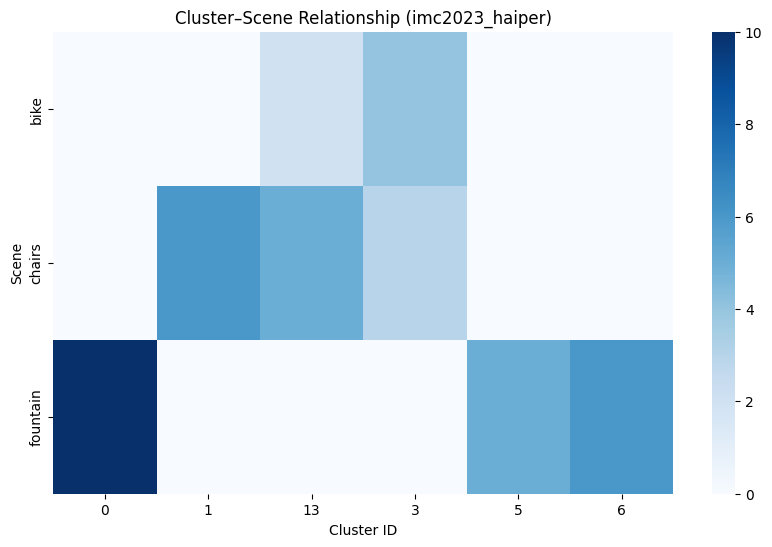

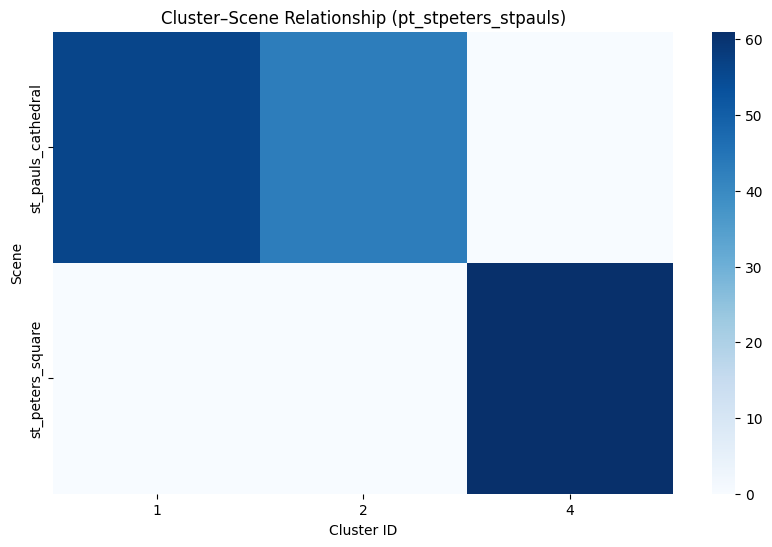

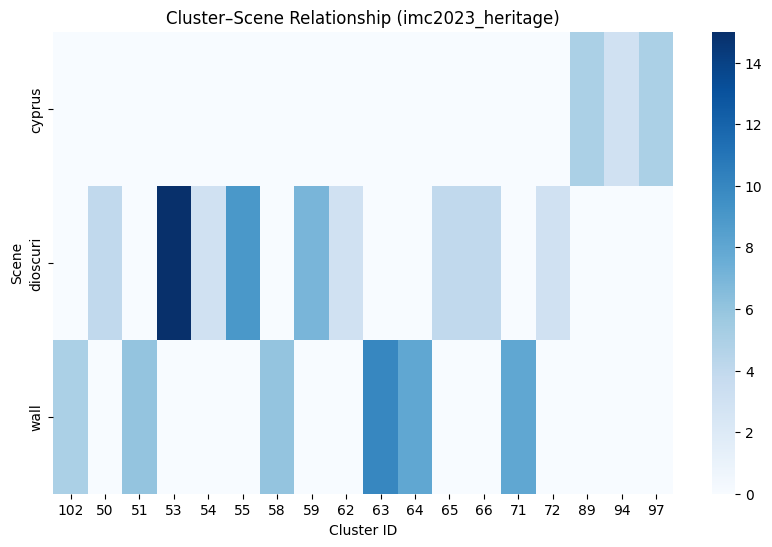

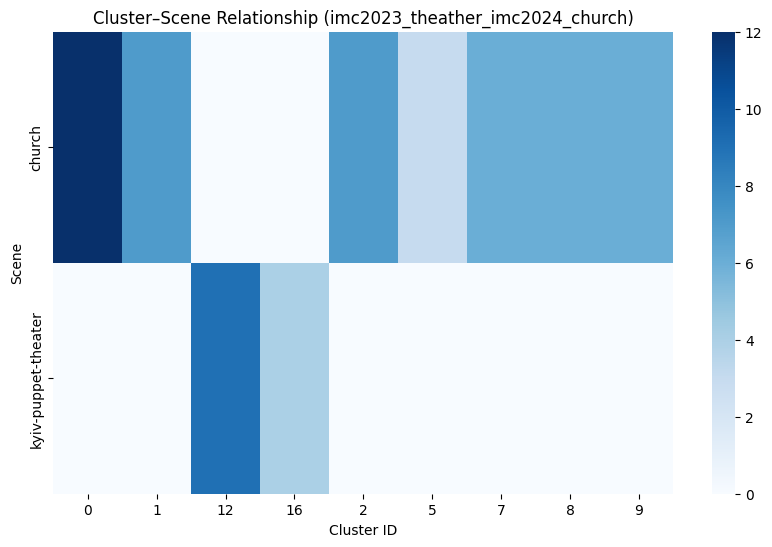

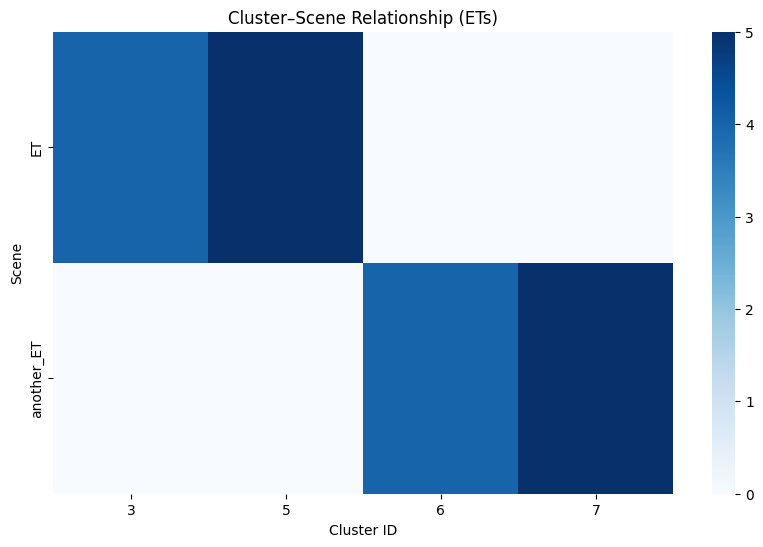

                             dataset cluster_id    majority_scene  precision  \
0                       fbk_vineyard          0  vineyard_split_2        1.0   
1                       fbk_vineyard         10  vineyard_split_2        1.0   
2                       fbk_vineyard         12  vineyard_split_1        1.0   
3                       fbk_vineyard         14  vineyard_split_3        1.0   
4                       fbk_vineyard         16  vineyard_split_1        1.0   
..                               ...        ...               ...        ...   
126  imc2023_theather_imc2024_church          9            church        1.0   
127                              ETs          3                ET        1.0   
128                              ETs          5                ET        1.0   
129                              ETs          6        another_ET        1.0   
130                              ETs          7        another_ET        1.0   

       recall        f1  size  outliers

In [11]:
# Load ground truth
labels = pd.read_csv(train_label_path)
# expected columns: dataset, scene, image

# Load clusters
with open(cluster_flann_disk_path) as f:
    clusters = json.load(f)

results = []

for dataset, content in clusters.items():
    records = []
    if not content["clusters"].items():
        continue
        
    for cluster_id, imgs in content["clusters"].items():
        for img in imgs:
            records.append([dataset, cluster_id, img])
    df_clusters = pd.DataFrame(records, columns=["dataset", "cluster_id", "image"])

    # Merge with ground truth
    df = df_clusters.merge(labels, on=["dataset", "image"], how="left")

    cluster_metrics = []

    for cluster_id, group in df.groupby("cluster_id"):
        scene_counts = Counter(group["scene"])
        if not scene_counts:
            continue

        # Majority scene
        majority_scene, majority_count = scene_counts.most_common(1)[0]
        total_cluster = len(group)

        # Precision = purity
        precision = majority_count / total_cluster

        # Recall = how much of that scene we captured
        total_scene_images = len(labels[(labels["dataset"] == dataset) & 
                                        (labels["scene"] == majority_scene)])
        recall = majority_count / total_scene_images

        # F1
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

        cluster_metrics.append({
            "dataset": dataset,
            "cluster_id": cluster_id,
            "majority_scene": majority_scene,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "size": total_cluster,
            "outliers": total_cluster - majority_count
        })

    cluster_report = pd.DataFrame(cluster_metrics)
    results.append(cluster_report)

    # Heatmap cluster vs. scene
    confusion = pd.crosstab(df["scene"], df["cluster_id"])
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion, cmap="Blues")
    plt.title(f"Cluster–Scene Relationship ({dataset})")
    plt.xlabel("Cluster ID")
    plt.ylabel("Scene")
    plt.show()

# Combine all datasets into one big table
final_report = pd.concat(results, ignore_index=True)
print(final_report)

In [13]:
from evaluation.eval import evaluate_clusters_comprehensive

In [15]:
evaluate_clusters_comprehensive(cluster_flann_disk_path, train_label_path)

# For dataset stairs: there is no clustered images found in dataset labels, so the dataset will not be evaluated
# In this case only 12 datasets will be evaluated for flann with disk


Evaluating dataset: fbk_vineyard

Evaluating dataset: pt_sacrecoeur_trevi_tajmahal

Evaluating dataset: pt_piazzasanmarco_grandplace

Evaluating dataset: imc2024_lizard_pond

Evaluating dataset: pt_brandenburg_british_buckingham

Evaluating dataset: amy_gardens

Evaluating dataset: imc2024_dioscuri_baalshamin

Evaluating dataset: imc2023_haiper

Evaluating dataset: pt_stpeters_stpauls

Evaluating dataset: imc2023_heritage

Evaluating dataset: imc2023_theather_imc2024_church

Evaluating dataset: stairs

Evaluating dataset: ETs


{'fbk_vineyard': {'cluster_statistics': {'total_clusters': 28,
   'total_images': 139,
   'cluster_sizes': [4,
    4,
    3,
    4,
    6,
    4,
    3,
    3,
    4,
    10,
    3,
    7,
    5,
    6,
    6,
    5,
    8,
    6,
    3,
    3,
    3,
    6,
    4,
    13,
    4,
    5,
    4,
    3],
   'avg_cluster_size': np.float64(4.964285714285714),
   'std_cluster_size': np.float64(2.2910094914242323),
   'min_cluster_size': 3,
   'max_cluster_size': 13,
   'scene_distribution': {1: 28},
   'dataset_distribution': {1: 28}},
  'scene_metrics': {'overall_precision': np.float64(1.0),
   'overall_recall': np.float64(0.22883597883597884),
   'overall_f1_score': np.float64(0.3656145384983262),
   'per_scene_results': {'vineyard_split_1': {'cluster_id': 23,
     'precision': 1.0,
     'recall': np.float64(0.3333333333333333),
     'f1_score': np.float64(0.5),
     'common_images': 13,
     'cluster_size': 13,
     'scene_size': np.int64(39)},
    'vineyard_split_2': {'cluster_id': 7,
  